# Model Training

First of all we need... the imports!
<br>
<small>So we don't code an ML algorithm by hand(I might do that for a future mini project)

In [32]:
#Regular ML stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#NN Stuff(AKA Keras)
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

#sklearn for metrics(mainly)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight

Alright first and foremost we need to define some variables and constants
Below I will define our target variable(y) and our features(X)

In [33]:
df = pd.read_csv(r"TrainData.csv")
X = df.drop(columns=["label"])
y = df["label"]
WINDOW_SIZE = 5
NUM_FEATURES = 14

Alright what we're going to do next is define a function to help us group together frames (or in this case we're "windowing" it) so we dont train per FRAME but FRAMES according to their features
<br>
<small>This is a very common thing to do in Time Series tasks

In [34]:
def make_windows(X, y, window_size, flatten=True):
    X_windowed, y_windowed = [], []
    num_features = X.shape[1]

    for i in range(window_size, len(X)):
        window = X.iloc[i - window_size : i].to_numpy()
        label = y.iloc[i]

        if flatten:
            window = np.reshape(window, (window_size * num_features,))

        X_windowed.append(window)
        y_windowed.append(label)

    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = make_windows(X, y, WINDOW_SIZE, flatten=True) #<--- We're just going to instantly define this to avoid hassle

Our data is skewed, for a good reason since a lot of the motions in drumming arent necessarily hits, e.g if you're lifting your hand up from a hit that doesn't count as a hit but a motion

Anyways enough jibber jabber about that we need to make sure the model isn't BIASED towards the majority class, which in this case is class 0 (or NO hit), so we need to apply class weights

In [35]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_windowed), y=y_windowed
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

We're going to do what every ML engineer is doing right now, yeah its splitting the data set into train and test
<br>
Its mandatory at this point to do this because... why wouldn't you

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)

Next we must thank Tensorflow (Ty Tensorflow!) for Keras

<br>Ok we must stay focused on our goal, we will now build the model
<br>Our WIDE LAYER or first layer will have 128 **neurons** (or units) and will use the **ReLU** algorithm to activate the neurons
<br>Then our HIDDEN LAYER will have 64 **neurons**, like before we will use the ReLU algorithm to activate the neurons
<br>Finally our last layer will only use 1 **neuron** and it will be activated by the **Sigmoid** Function

<br>Compile wise we will optimize the model using Adam, have the loss be binary_crossentropy and we will need to see the metrics

In [37]:
# Build model
MLP = Sequential()
MLP.add(Dense(128, activation="relu", input_shape=(X_train.shape[1],)))
MLP.add(Dense(64, activation="relu"))
MLP.add(Dense(1, activation="sigmoid"))

# Compile the model
MLP.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now we will train the model
<br>We will be doing 20 epochs (or steps) and we will include our class weight

In [38]:
MLP.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
)

Epoch 1/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6805 - loss: 1.2354 - val_accuracy: 0.7755 - val_loss: 0.4893
Epoch 2/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7545 - loss: 0.5712 - val_accuracy: 0.7247 - val_loss: 0.5794
Epoch 3/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7638 - loss: 0.5065 - val_accuracy: 0.7800 - val_loss: 0.4682
Epoch 4/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7912 - loss: 0.4693 - val_accuracy: 0.7398 - val_loss: 0.5369
Epoch 5/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7881 - loss: 0.4580 - val_accuracy: 0.7862 - val_loss: 0.4948
Epoch 6/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8035 - loss: 0.4407 - val_accuracy: 0.7747 - val_loss: 0.4783
Epoch 7/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8129 - loss: 0.4245 - val_accuracy: 0.7524 - val_loss: 0.5136
Epoch 8/20
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8083 - loss: 0.4123 - val_accuracy: 0.

# Model Evaluation

Alrighty now we got that but wait... how do we know if its good?
<br>Now we get into the metrics (the most BORING part)

In [39]:
#We're gonna start off basic
metrics = MLP.evaluate(X_test, y_test)
print(metrics)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.3163
[0.30914366245269775, 0.8776944875717163]


That's a cool little way to do it but there isn't much we can get from that
<br>So we'll need to do a little bit more, a good way to measure accuracy is by using a confusion matrix (refer to the image I attached if you don't know how to read one) 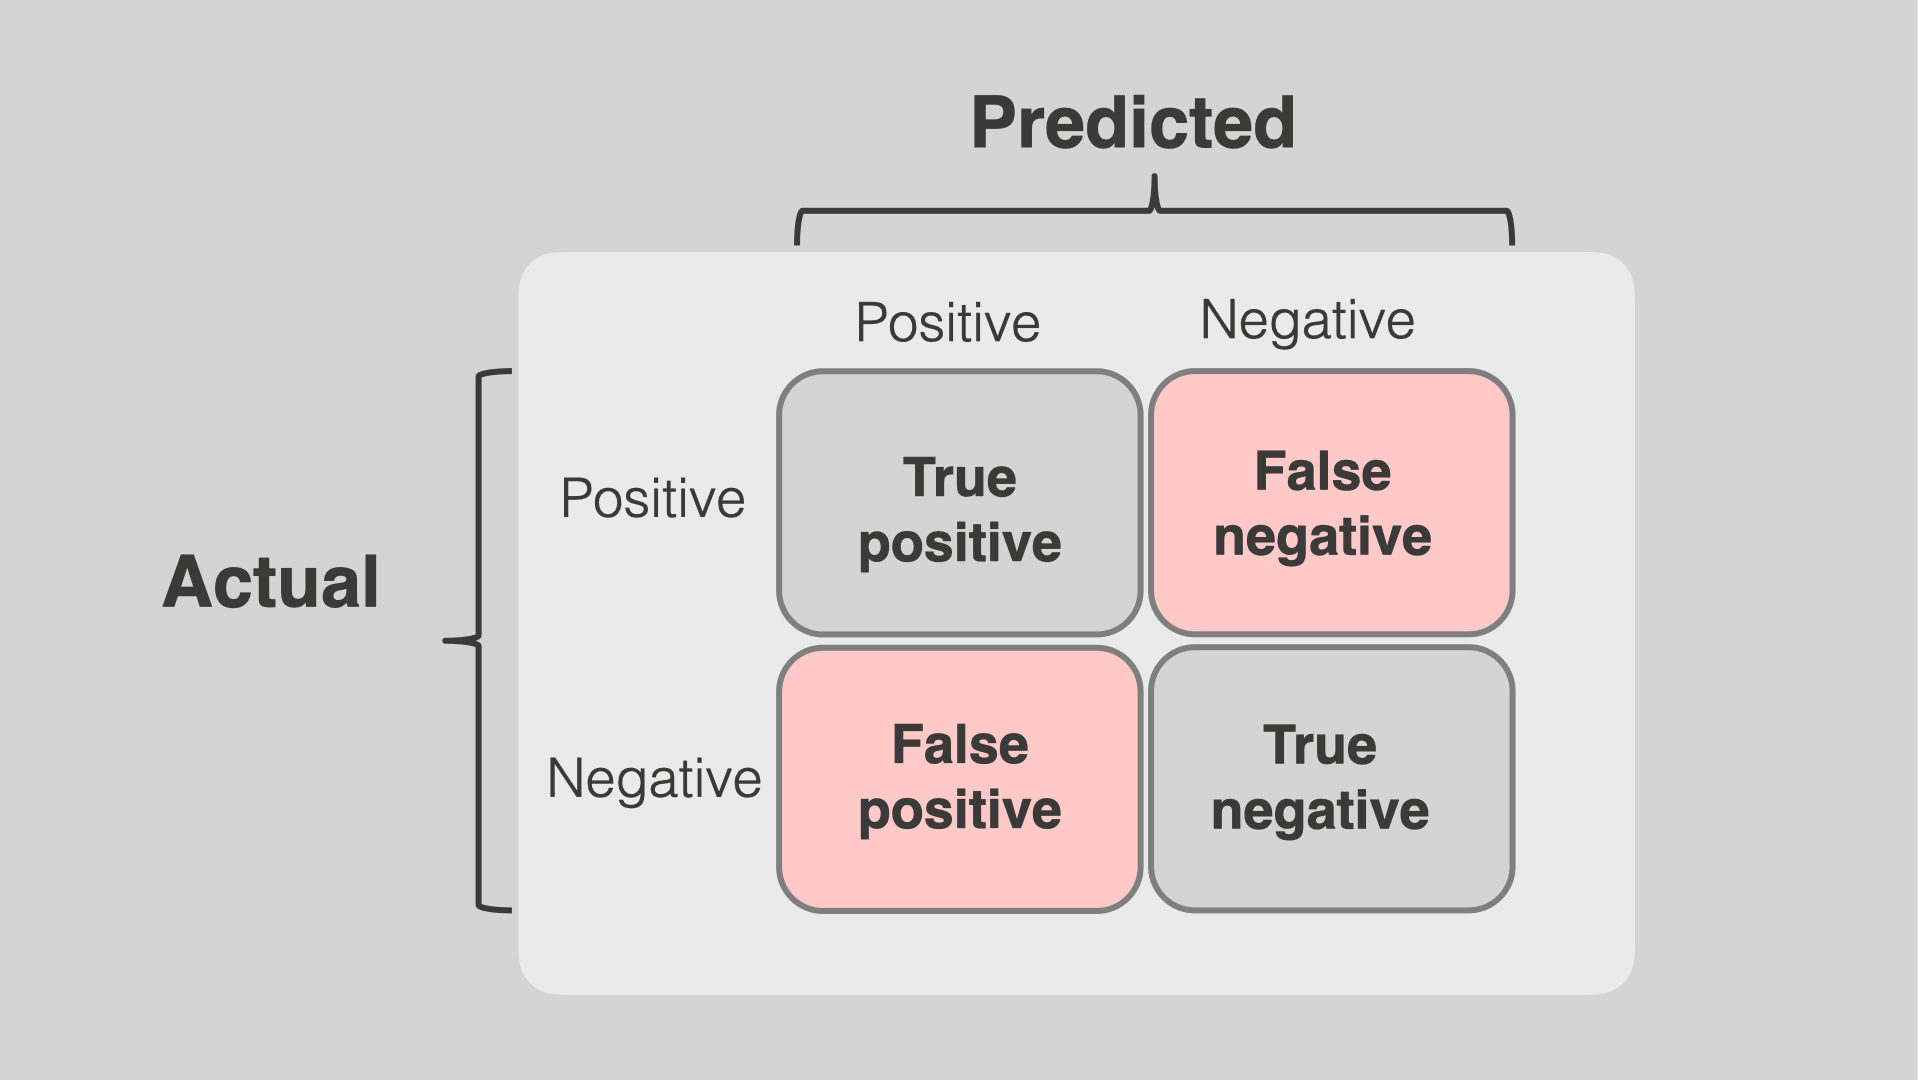

In [40]:
y_pred_probs = MLP.predict(X_test)
for t in [0.3,0.4,0.5,0.6,0.7]:
    y_pred = (y_pred_probs > t).astype(int)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4505  930]
 [ 149  818]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      5435
           1       0.47      0.85      0.60       967

    accuracy                           0.83      6402
   macro avg       0.72      0.84      0.75      6402
weighted avg       0.89      0.83      0.85      6402

[[4735  700]
 [ 199  768]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      5435
           1       0.52      0.79      0.63       967

    accuracy                           0.86      6402
   macro avg       0.74      0.83      0.77      6402
weighted avg       0.89      0.86      0.87      6402

[[4908  527]
 [ 256  711]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      5435
           1       0.57      0.74      0.64       967

    accuracy                           0.88      6402
   mac

We got some pretty good scores, but what do we do with them?
<br>Here's where Precision vs Recall comes into play
<br>To put it simply,
- Lower threshold → More recall, less precision (catch everything, even false alarms).
- Higher threshold → more precision, less recall (only confident hits, but you miss some).
<br>The plot below shows the Precision-Recall curve, which shows the tradeoff between catching more true congested roads (recall) and avoiding false alarms (precision).

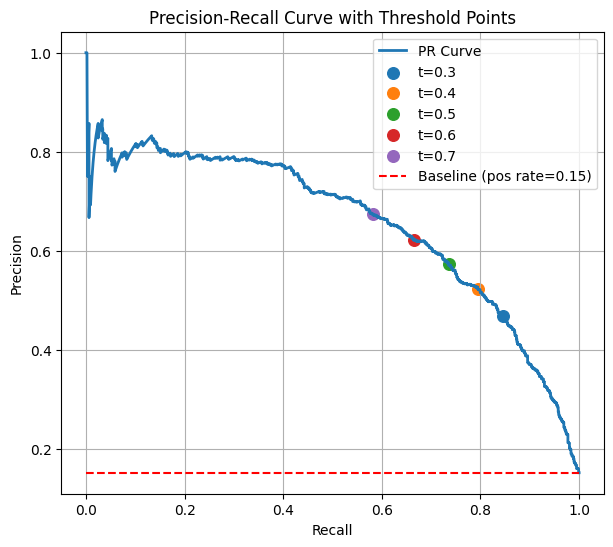

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
plt.figure(figsize=(7, 6))
plt.plot(recalls, precisions, label="PR Curve", linewidth=2)

#Of course we're not gonna use EVERY threshold, but some so we're gonna use some common ones, and ones I had some good results with(I started at 0.4 and 0.6 and they gave me good results so I just added 0.1 to the min and max so it as a wider range)
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    idx = np.argmin(np.abs(thresholds - t))  # closest threshold index
    plt.scatter(recalls[idx], precisions[idx], label=f"t={t}", s=70)
# Random baseline (always predicting positive = proportion of positives in test set)
baseline = np.sum(y_test) / len(y_test)
plt.hlines(
    y=baseline,
    xmin=0,
    xmax=1,
    colors="red",
    linestyles="dashed",
    label=f"Baseline (pos rate={baseline:.2f})",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Threshold Points")
plt.legend()
plt.grid(True)
plt.show()


Now we need to compare to show you our model isn't just a bluff, here is our dummy model which just gives you baseline accuracy, in layman terms it says "What if I just guessed the most common class how accurate would I be"

In [42]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print("Baseline acc:", dummy.score(X_test, y_test))

Baseline acc: 0.8489534520462355


Now we compare the two

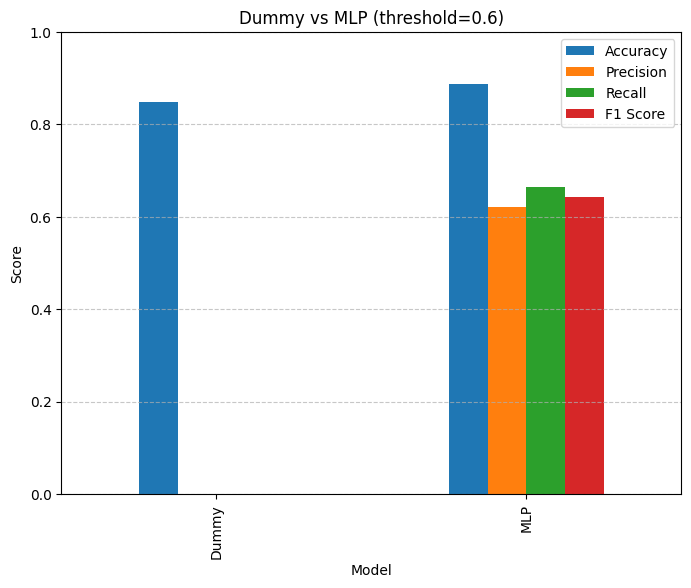

,Model,Accuracy,Precision,Recall,F1 Score
0,Dummy,0.848953,0.000000,0.000000,0.000000
1,MLP,0.888316,0.621857,0.664943,0.642679


In [43]:
y_dummy_pred = dummy.predict(X_test)
THRESHOLD = 0.6
y_mlp_pred = (y_pred_probs > THRESHOLD).astype(int)

#Metrics for both models
metrics_dict = {
    "Model": ["Dummy", "MLP"],
    "Accuracy": [
        accuracy_score(y_test, y_dummy_pred),
        accuracy_score(y_test, y_mlp_pred),
    ],
    "Precision": [
        precision_score(y_test, y_dummy_pred, zero_division=0),
        precision_score(y_test, y_mlp_pred, zero_division=0),
    ],
    "Recall": [
        recall_score(y_test, y_dummy_pred, zero_division=0),
        recall_score(y_test, y_mlp_pred, zero_division=0),
    ],
    "F1 Score": [
        f1_score(y_test, y_dummy_pred, zero_division=0),
        f1_score(y_test, y_mlp_pred, zero_division=0),
    ],
}

results_df = pd.DataFrame(metrics_dict)

#Bar chart to compare accuracies
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(
    kind="bar", figsize=(8, 6)
)
plt.title(f"Dummy vs MLP (threshold={THRESHOLD})")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Display raw numbers too
results_df

<br>You might be like "Dude the dummy is like almost as accurate", the MLP not only beats the Dummy classifier in accuracy but, more importantly, it actually identifies the minority class with decent recall and precision. The Dummy looks good on accuracy alone but is basically useless in practice
<br>What we really needed was the precision and recall, which should give us great results moving forward